<a href="https://colab.research.google.com/github/ntnuYuhsuan/113-1-AIOT-hw1/blob/main/diabets_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch numpy matplotlib

In [2]:
!wget https://github.com/hunkim/PyTorchZeroToAll/raw/master/data/diabetes.csv.gz -O diabetes.csv.gz

--2024-11-09 03:55:01--  https://github.com/hunkim/PyTorchZeroToAll/raw/master/data/diabetes.csv.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/diabetes.csv.gz [following]
--2024-11-09 03:55:02--  https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/diabetes.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13539 (13K) [application/octet-stream]
Saving to: ‘diabetes.csv.gz’

diabetes.csv.gz     100%[===================>]  13.22K  --.-KB/s    in 0s      

2024-11-09 03:55:02 (64.5 MB/s) - ‘diabetes.csv.gz’ saved [13539/13539]



device: cuda
特徵形狀: torch.Size([759, 8]) | 標籤形狀: torch.Size([759, 1])

使用配置: ReLU + Adam
Epoch: 50/500 | Loss: 0.5443
Epoch: 100/500 | Loss: 0.4806
Epoch: 150/500 | Loss: 0.3828
Epoch: 200/500 | Loss: 0.3692
Epoch: 250/500 | Loss: 0.3268
Epoch: 300/500 | Loss: 0.3024
Epoch: 350/500 | Loss: 0.2492
Epoch: 400/500 | Loss: 0.2367
Epoch: 450/500 | Loss: 0.2340
Epoch: 500/500 | Loss: 0.1892

使用配置: PReLU + Adam
Epoch: 50/500 | Loss: 0.5211
Epoch: 100/500 | Loss: 0.4620
Epoch: 150/500 | Loss: 0.4219
Epoch: 200/500 | Loss: 0.3854
Epoch: 250/500 | Loss: 0.3802
Epoch: 300/500 | Loss: 0.2946
Epoch: 350/500 | Loss: 0.2726
Epoch: 400/500 | Loss: 0.2398
Epoch: 450/500 | Loss: 0.2305
Epoch: 500/500 | Loss: 0.2151

使用配置: ReLU + AdamW
Epoch: 50/500 | Loss: 0.5609
Epoch: 100/500 | Loss: 0.4855
Epoch: 150/500 | Loss: 0.4208
Epoch: 200/500 | Loss: 0.3747
Epoch: 250/500 | Loss: 0.3795
Epoch: 300/500 | Loss: 0.3491
Epoch: 350/500 | Loss: 0.3026
Epoch: 400/500 | Loss: 0.2762
Epoch: 450/500 | Loss: 0.2748
Epoch

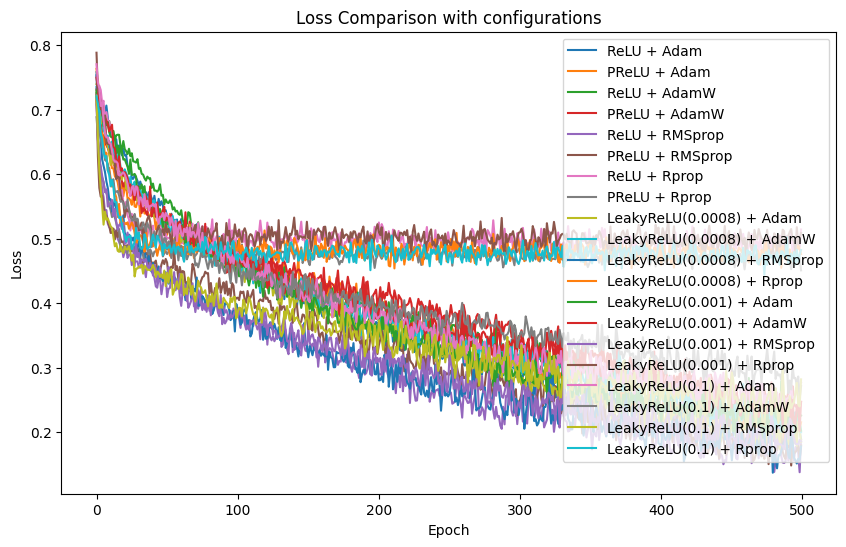

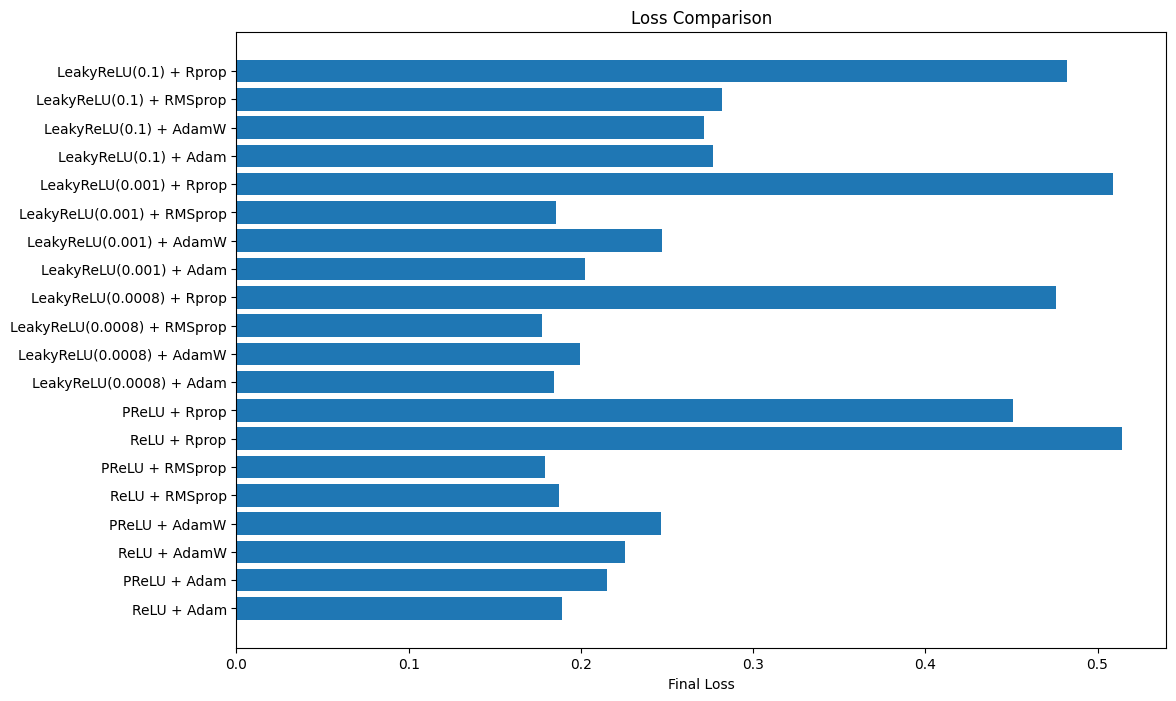

In [ ]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

xy = np.loadtxt('./diabetes.csv.gz', delimiter=',', dtype=np.float32)
x_data = torch.from_numpy(xy[:, 0:-1]).to(device)
y_data = torch.from_numpy(xy[:, [-1]]).to(device)
print(f"特徵形狀: {x_data.shape} | 標籤形狀: {y_data.shape}")

x_mean = x_data.mean(dim=0, keepdim=True)
x_std = x_data.std(dim=0, unbiased=False, keepdim=True)
x_data = (x_data - x_mean) / x_std

def plot_loss(loss_history, title):
    plt.figure(figsize=(10, 6))
    for label, losses in loss_history.items():
        plt.plot(losses, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

class ComplexModel(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(ComplexModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 256),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(32),

            nn.Linear(32, 16),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(16),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def train_model(activation_fn, optimizer_fn, epochs=500, learning_rate=0.0012, weight_decay=0.01):
    model = ComplexModel(activation_fn=activation_fn).to(device)
    criterion = nn.BCELoss()
    if optimizer_fn == optim.Rprop:
        optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
    else:
        optimizer = optimizer_fn(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    loss_history = []

    for epoch in range(epochs):
        model.train()
        y_pred = model(x_data)
        loss = criterion(y_pred, y_data)
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f'Epoch: {epoch + 1}/{epochs} | Loss: {loss.item():.4f}')

    return loss_history

negative_slope_values = [0.0008, 0.001, 0.1]

optimizer_list = [
    ("Adam", optim.Adam),
    ("AdamW", optim.AdamW),
    ("RMSprop", optim.RMSprop),
    ("Rprop", optim.Rprop)

]
configurations = []
for opt_name, opt_fn in optimizer_list:
    configurations.append(("ReLU + " + opt_name, nn.ReLU(), opt_fn))
    configurations.append(("PReLU + " + opt_name, nn.PReLU(), opt_fn))

for ns in negative_slope_values:
    for opt_name, opt_fn in optimizer_list:
        config_name = f"LeakyReLU({ns}) + {opt_name}"
        configurations.append((config_name, nn.LeakyReLU(negative_slope=ns), opt_fn))

loss_histories = {}

for name, activation_fn, optimizer_fn in configurations:
    print(f"\n使用配置: {name}")
    loss_history = train_model(
        activation_fn=activation_fn,
        optimizer_fn=optimizer_fn,
        epochs=500,
        learning_rate=0.0012,
        weight_decay=0.01
    )
    loss_histories[name] = loss_history

plot_loss(loss_histories, "Loss Comparison with configurations")

final_losses = {name: losses[-1] for name, losses in loss_histories.items()}
plt.figure(figsize=(12, 8))
plt.barh(list(final_losses.keys()), list(final_losses.values()))
plt.xlabel('Final Loss')
plt.title('Loss Comparison')
plt.show()

Using device: cuda
X's shape: torch.Size([759, 8]) | Y's shape: torch.Size([759, 1])

Training with configuration: LeakyReLU + RMSprop
Epoch: 20/500 | Loss: 0.5008
Epoch: 40/500 | Loss: 0.4361
Epoch: 60/500 | Loss: 0.3906
Epoch: 80/500 | Loss: 0.3530
Epoch: 100/500 | Loss: 0.3432
Epoch: 120/500 | Loss: 0.3132
Epoch: 140/500 | Loss: 0.2879
Epoch: 160/500 | Loss: 0.2886
Epoch: 180/500 | Loss: 0.2695
Epoch: 200/500 | Loss: 0.2700
Epoch: 220/500 | Loss: 0.2491
Epoch: 240/500 | Loss: 0.2495
Epoch: 260/500 | Loss: 0.2150
Epoch: 280/500 | Loss: 0.2137
Epoch: 300/500 | Loss: 0.1934
Epoch: 320/500 | Loss: 0.2254
Epoch: 340/500 | Loss: 0.2116
Epoch: 360/500 | Loss: 0.1542
Epoch: 380/500 | Loss: 0.1500
Epoch: 400/500 | Loss: 0.1950
Epoch: 420/500 | Loss: 0.1532
Epoch: 440/500 | Loss: 0.1588
Epoch: 460/500 | Loss: 0.1587
Epoch: 480/500 | Loss: 0.1435
Epoch: 500/500 | Loss: 0.1384

Training with configuration: PReLU + RMSprop
Epoch: 20/500 | Loss: 0.4871
Epoch: 40/500 | Loss: 0.4557
Epoch: 60/500 |

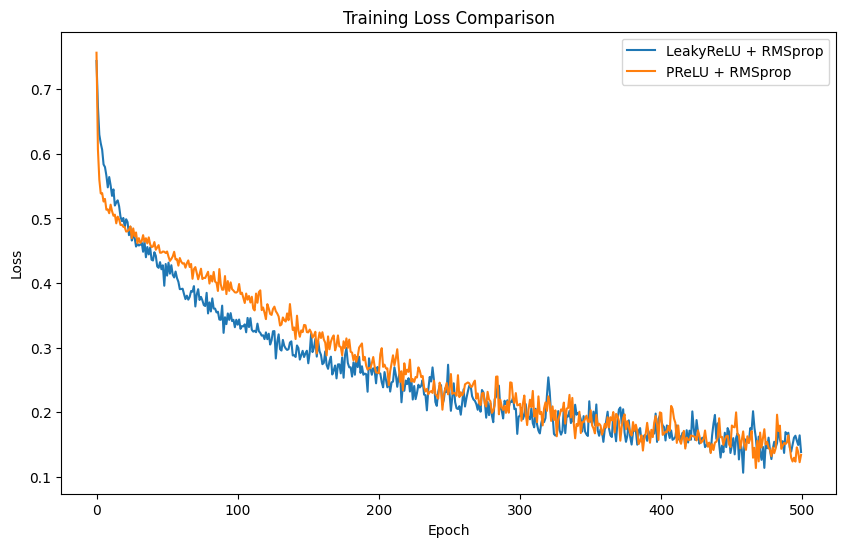

In [4]:
import torch
from torch import nn, optim, from_numpy
import numpy as np
import matplotlib.pyplot as plt

# 確認 CUDA 可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 載入數據
xy = np.loadtxt('./diabetes.csv.gz', delimiter=',', dtype=np.float32)
x_data = from_numpy(xy[:, 0:-1]).to(device)
y_data = from_numpy(xy[:, [-1]]).to(device)
print(f"X's shape: {x_data.shape} | Y's shape: {y_data.shape}")

# 訓練過程可視化的函數
def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    for label, loss_values in history.items():
        plt.plot(loss_values, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()
class ImprovedModel(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(ImprovedModel, self).__init__()
        self.layers = nn.Sequential(
            # 特徵提取階段 (寬而淺)
            nn.Linear(8, 128),
            activation_fn,
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),

            # 特徵壓縮階段 (窄而深)
            nn.Linear(128, 64),
            activation_fn,
            nn.Dropout(0.3),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            activation_fn,
            nn.BatchNorm1d(32),

            nn.Linear(32, 16),
            activation_fn,
            nn.BatchNorm1d(16),

            nn.Linear(16, 8),
            activation_fn,
            nn.BatchNorm1d(8),

            nn.Linear(8, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)


class ComplexModel(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(ComplexModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 256),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(32),

            nn.Linear(32, 16),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(16),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def train_model(activation_fn, optimizer_fn, epochs=400, learning_rate=0.001, weight_decay=0.01):
    model = ImprovedModel(activation_fn=activation_fn).to(device)
    criterion = nn.BCELoss(reduction='mean')
    if optimizer_fn == optim.Rprop:
        optimizer = optimizer_fn(model.parameters(), lr=learning_rate)
    else:
        optimizer = optimizer_fn(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


    loss_history = []

    for epoch in range(epochs):
        model.train()
        y_pred = model(x_data)
        loss = criterion(y_pred, y_data)
        loss_history.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch: {epoch + 1}/{epochs} | Loss: {loss.item():.4f}')

    return loss_history

configurations = [
    ("LeakyReLU + RMSprop", nn.LeakyReLU(negative_slope=0.0008), optim.RMSprop),
    ("PReLU + RMSprop", nn.PReLU(), optim.RMSprop),
    # ("LeakyReLU + Rprop", nn.LeakyReLU(negative_slope=0.001), optim.Rprop),
    # ("PReLU + Rprop", nn.PReLU(), optim.Rprop)
]

loss_histories = {}

for name, activation_fn, optimizer_fn in configurations:
    print(f"\nTraining with configuration: {name}")
    loss_history = train_model(activation_fn, optimizer_fn, epochs=500, learning_rate=0.0012, weight_decay=0.006)
    loss_histories[name] = loss_history

plot_loss(loss_histories, "Training Loss Comparison")


In [ ]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

xy = np.loadtxt('./diabetes.csv.gz', delimiter=',', dtype=np.float32)
x_data = torch.from_numpy(xy[:, 0:-1]).to(device)
y_data = torch.from_numpy(xy[:, [-1]]).to(device)
print(f"特徵形狀: {x_data.shape} | 標籤形狀: {y_data.shape}")

x_mean = x_data.mean(dim=0, keepdim=True)
x_std = x_data.std(dim=0, unbiased=False, keepdim=True)
x_data = (x_data - x_mean) / x_std

class ComplexModel(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(ComplexModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 256),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(256),

            nn.Linear(256, 128),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(32),

            nn.Linear(32, 16),
            activation_fn,
            nn.Dropout(0.4),
            nn.BatchNorm1d(16),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def train_model(model, criterion, optimizer, x_train, y_train, x_val, y_val, epochs=500):
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = criterion(y_val_pred, y_val)

        loss_history.append(train_loss.item())
        val_loss_history.append(val_loss.item())

        if (epoch + 1) % 50 == 0:
            print(f'Epoch: {epoch + 1}/{epochs} | Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f}')

    return loss_history, val_loss_history

def optimize_parameters(
    x_data,
    y_data,
    activation_fns,
    optimizer_fns,
    learning_rates,
    weight_decays,
    epochs=500,
    validation_split=0.2
):
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=validation_split, random_state=42)

    best_loss = float('inf')
    best_config = None

    for activation_fn in activation_fns:
        for optimizer_fn in optimizer_fns:
            for lr in learning_rates:
                for wd in weight_decays:
                    print(f"\n使用配置: 激活函數={activation_fn.__class__.__name__}, 優化器={optimizer_fn.__name__}, 學習率={lr}, 權重衰減={wd}")
                    model = ComplexModel(activation_fn=activation_fn).to(device)
                    criterion = nn.BCELoss()
                    if optimizer_fn == optim.Rprop:
                        optimizer = optimizer_fn(model.parameters(), lr=lr)
                    else:
                        optimizer = optimizer_fn(model.parameters(), lr=lr, weight_decay=wd)

                    train_loss, val_loss = train_model(model, criterion, optimizer, x_train, y_train, x_val, y_val, epochs)
                    final_val_loss = val_loss[-1]

                    if final_val_loss < best_loss:
                        best_loss = final_val_loss
                        best_config = {
                            "activation_fn": activation_fn,
                            "optimizer_fn": optimizer_fn,
                            "learning_rate": lr,
                            "weight_decay": wd
                        }

                    print(f"最終驗證集損失: {final_val_loss:.4f}")

    return best_config, best_loss

# 定義參數範圍
activation_fns = [nn.ReLU(), nn.PReLU(), nn.LeakyReLU(negative_slope=0.01)]
optimizer_fns = [optim.Adam, optim.AdamW, optim.RMSprop, optim.Rprop]
learning_rates = [0.001, 0.0012, 0.002]
weight_decays = [0.01, 0.005, 0.001]

best_config, best_loss = optimize_parameters(
    x_data, y_data,
    activation_fns=activation_fns,
    optimizer_fns=optimizer_fns,
    learning_rates=learning_rates,
    weight_decays=weight_decays,
    epochs=500
)

print(f"\n最佳配置: \n激活函數 = {best_config['activation_fn'].__class__.__name__}\n優化器 = {best_config['optimizer_fn'].__name__}\n學習率 = {best_config['learning_rate']}\n權重衰減 = {best_config['weight_decay']}\n最終驗證集損失 = {best_loss:.4f}")

device: cuda
特徵形狀: torch.Size([759, 8]) | 標籤形狀: torch.Size([759, 1])

使用配置: 激活函數=ReLU, 優化器=Adam, 學習率=0.001, 權重衰減=0.01
Epoch: 50/500 | Train Loss: 0.5531 | Val Loss: 0.4906
Epoch: 100/500 | Train Loss: 0.4843 | Val Loss: 0.4666
Epoch: 150/500 | Train Loss: 0.4486 | Val Loss: 0.4562
Epoch: 200/500 | Train Loss: 0.3880 | Val Loss: 0.4439
Epoch: 250/500 | Train Loss: 0.3568 | Val Loss: 0.4636
Epoch: 300/500 | Train Loss: 0.2883 | Val Loss: 0.4941
Epoch: 350/500 | Train Loss: 0.2913 | Val Loss: 0.5040
Epoch: 400/500 | Train Loss: 0.2512 | Val Loss: 0.5359
Epoch: 450/500 | Train Loss: 0.2365 | Val Loss: 0.5416
Epoch: 500/500 | Train Loss: 0.1782 | Val Loss: 0.6155
最終驗證集損失: 0.6155

使用配置: 激活函數=ReLU, 優化器=Adam, 學習率=0.001, 權重衰減=0.005
Epoch: 50/500 | Train Loss: 0.5543 | Val Loss: 0.5231
Epoch: 100/500 | Train Loss: 0.4858 | Val Loss: 0.4924
Epoch: 150/500 | Train Loss: 0.4198 | Val Loss: 0.4678
Epoch: 200/500 | Train Loss: 0.3940 | Val Loss: 0.4712
Epoch: 250/500 | Train Loss: 0.3394 | Val Loss: 